* Spearmint for analogy reasoning
* Gaussian LDA
* Evaluate word analogy reasoning
* evalutate topic models
* find background noise
* find word pairs

# Setup

In [1]:
%matplotlib notebook

import itertools
import logging
from functools import partial

import gensim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pnd
from sklearn.cluster import *
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE
from codecs import open
import gc

from knub.thesis.util import *
matplotlib.style.use('ggplot')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render p, div.text_cell_render ul, table.dataframe {
font-size:1.3em;
line-height:1.1em;
}
</style>
""")

# Preprocessing

In [3]:
MODEL = "../models/topic-models/topic.full.alpha-1-100.256-400.model"
#MODEL = "../models/topic-models/topic.256-400.first-2000.alpha-001.beta-001.model"

In [4]:
print "Load vectors"
vectors = load_skip_gram()
model = TopicModelLoader(MODEL, vectors)
print "Load topic probs"
df_topic_probs_full = model.load_topic_probs()
print "Load topics"
df_topics = model.load_topics()
print "Load topic similars"
df_topic_similars = model.load_all_topic_similars()

Load vectors
Load topic probs
Load topics
Load topic similars


In [5]:
word_prob_lower_threshold = df_topic_probs_full["word-prob"].quantile(0.4)
word_prob_upper_threshold = df_topic_probs_full["word-prob"].quantile(0.99)

# Topic Probs Analysis

In [6]:
df_topic_probs = df_topic_probs_full[df_topic_probs_full["word"].apply(lambda w: w in model.topic_words)].copy()

word-prob does not sum to one, because we only write out frequent words

In [7]:
df_topic_probs_full["word-prob"].sum()

0.9603721877610281

In [8]:
def topic_prob_difference_from_first_to(row, n):
    s = sorted(row, reverse=True)
    return s[0] - s[n - 1]
    

for diff in [2, 5, 50]:
    column_name = "diff-" + str(diff)
    df_topic_probs_full[column_name] = df_topic_probs_full[model.prob_columns].apply(
        partial(topic_prob_difference_from_first_to, n=diff), axis=1)

## Strength of topic prevalence

### Against second best topic

<IPython.core.display.Javascript object>


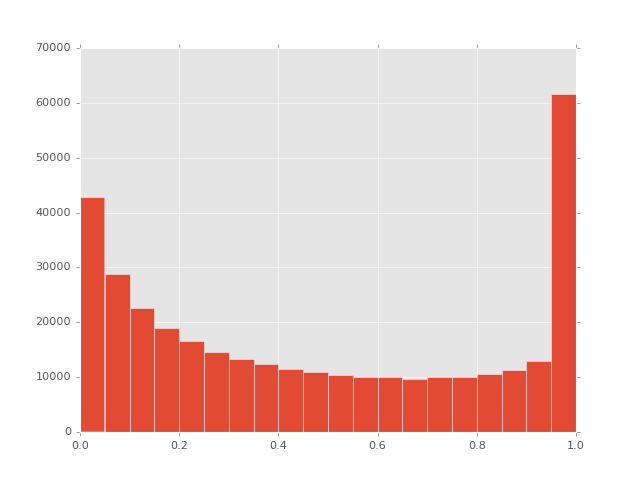

In [9]:
plt.figure()
df_topic_probs_full["diff-2"].hist(bins=20)

### Against fifth best topic

<IPython.core.display.Javascript object>


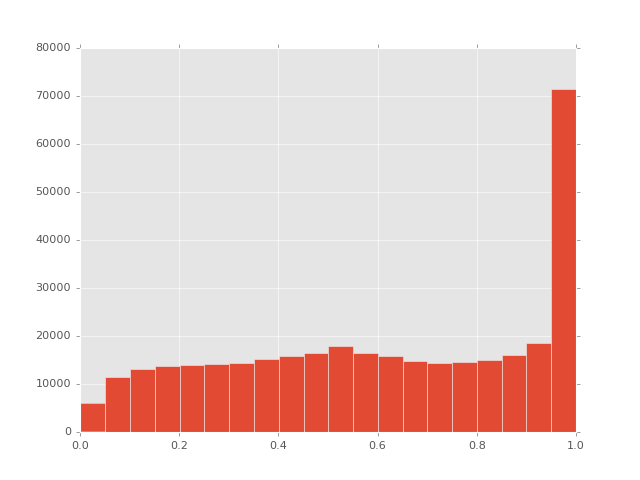

In [10]:
plt.figure()
df_topic_probs_full["diff-5"].hist(bins=20)

### Against fiftieth best topic

<IPython.core.display.Javascript object>


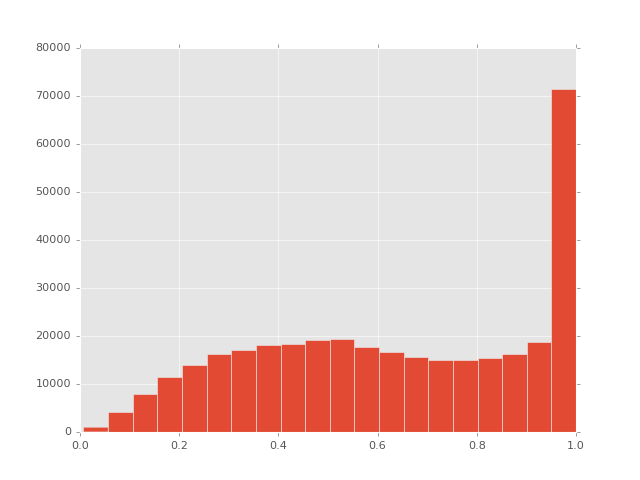

In [11]:
plt.figure()
df_topic_probs_full["diff-50"].hist(bins=20)

## Most common words

In [12]:
df_topic_probs_full.sort_values(by="word-prob", ascending=False).head(10)[["word", "word-prob"]]

,word,word-prob
1490,also,0.004686
3245,first,0.004077
1355,one,0.003606
5907,new,0.003460
2339,two,0.002904
3616,time,0.002163
2156,school,0.001988
7001,years,0.001947
351,may,0.001916
3116,would,0.001780


## Highest std. dev.

In [13]:
df_topic_probs["stddev"] = df_topic_probs[model.prob_columns].std(axis=1)
df_topic_probs.sort_values(by="stddev", ascending=False).head(10)[["word", "stddev"]]

,word,stddev
89573,gmina,0.062500
154769,cerambycidae,0.062500
43498,forewings,0.062341
120376,rabbi,0.061799
43347,moth,0.061736
277953,nascar,0.061622
119287,nigerian,0.061617
89560,voivodeship,0.061585
301489,kuala,0.061550
307513,nhl,0.061477


## Lowest std. dev.

In [14]:
df_topic_probs["stddev"] = df_topic_probs[model.prob_columns].std(axis=1)
df_topic_probs.sort_values(by="stddev", ascending=True).head(10)[["word", "stddev"]]

,word,stddev
1355,one,0.002358
1490,also,0.002516
2339,two,0.002998
3245,first,0.003318
2708,known,0.003707
3616,time,0.004129
5030,part,0.004133
3119,later,0.004259
21313,however,0.004622
15990,early,0.004699


# Correlation TM similarity and WE similarity

 Topic model similarity evaluated using different probability distribution similarity measures (evaluated on the normalized word-topic distributions):
 
 * [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)
 * [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance)
 * [Bhattacharyya coefficient](https://en.wikipedia.org/wiki/Bhattacharyya_distance#Bhattacharyya_coefficient)
 * Max difference
 * Sum difference ([total variation distance](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures))

### Ten most similar words for each top-10-topic word

In [15]:
df_topic_similars["jensen-shannon"].head()

,word,similar_word,tm_sim,we_sim
0,military,stationed,0.722825,0.391147
1,military,army’s,0.730260,0.566314
2,military,war,0.736751,0.287915
3,military,non-military,0.741515,0.643097
4,military,commanders,0.754676,0.564292


### Correlation between TM and WE similarity

In [16]:
model.sim_functions = ["max", "sum", "bhattacharyya", "hellinger", "jensen-shannon"]

sim_corrs_spearman = []
sim_corrs_pearson = []
for sim_function in model.sim_functions:
    corr_spearman = df_topic_similars[sim_function][["tm_sim", "we_sim"]].corr("spearman").ix[0,1]
    corr_pearson = df_topic_similars[sim_function][["tm_sim", "we_sim"]].corr("pearson").ix[0,1]
    sim_corrs_spearman.append(corr_spearman)
    sim_corrs_pearson.append(corr_pearson)

df_tmp = pnd.DataFrame(model.sim_functions, columns=["sim_function"])
df_tmp["sim_corr_spearman"] = sim_corrs_spearman
df_tmp["sim_corr_pearson"] = sim_corrs_pearson
df_tmp

,sim_function,sim_corr_spearman,sim_corr_pearson
0,max,-0.076134,-0.043531
1,sum,0.367308,0.349043
2,bhattacharyya,0.316480,0.312920
3,hellinger,0.316480,0.297119
4,jensen-shannon,0.331737,0.329467


In [17]:
def correlation_in_group(corr_function):
    def correlation(df_group):
        return df_group.ix[:,-2:].corr(corr_function).ix[0,1]
    return correlation

sim_corrs_spearman = []
sim_corrs_pearson = []
for sim_function in model.sim_functions:
    df_tmp = df_topic_similars[sim_function]
    df_group = df_tmp.groupby(np.arange(len(df_tmp)) // 10)
    corr_spearman = df_group.apply(correlation_in_group("spearman")).mean()
    corr_pearson = df_group.apply(correlation_in_group("pearson")).mean()

    sim_corrs_spearman.append(corr_spearman)
    sim_corrs_pearson.append(corr_pearson)

df_tmp = pnd.DataFrame(model.sim_functions, columns=["sim_function"])
df_tmp["sim_corr_spearman"] = sim_corrs_spearman
df_tmp["sim_corr_pearson"] = sim_corrs_pearson
df_tmp


,sim_function,sim_corr_spearman,sim_corr_pearson
0,max,0.184915,0.220690
1,sum,0.282030,0.341541
2,bhattacharyya,0.311571,0.388735
3,hellinger,0.311571,0.390448
4,jensen-shannon,0.304427,0.375609


**Note: Similar results Google vectors**

### Distribution of TM similarity

<IPython.core.display.Javascript object>


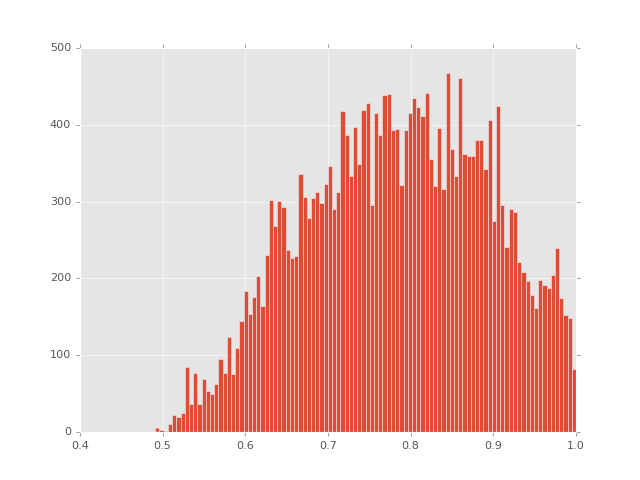

In [18]:
plt.figure()
df_topic_similars["jensen-shannon"]["tm_sim"].hist(bins=100)

### Distribution of WE similarity

<IPython.core.display.Javascript object>


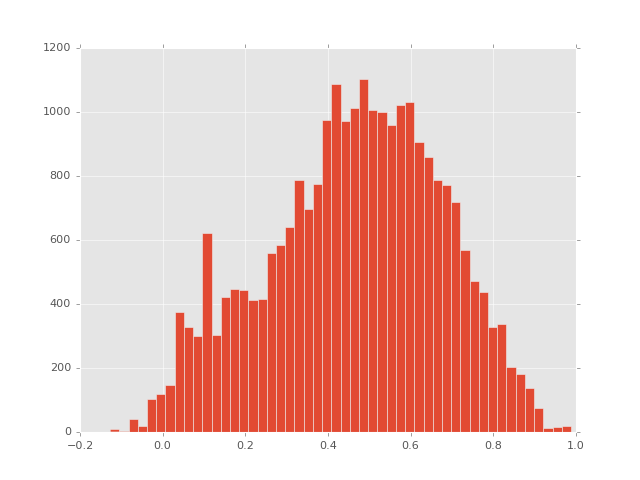

In [19]:
plt.figure()
df_topic_similars["jensen-shannon"]["we_sim"].hist(bins=50)

<IPython.core.display.Javascript object>


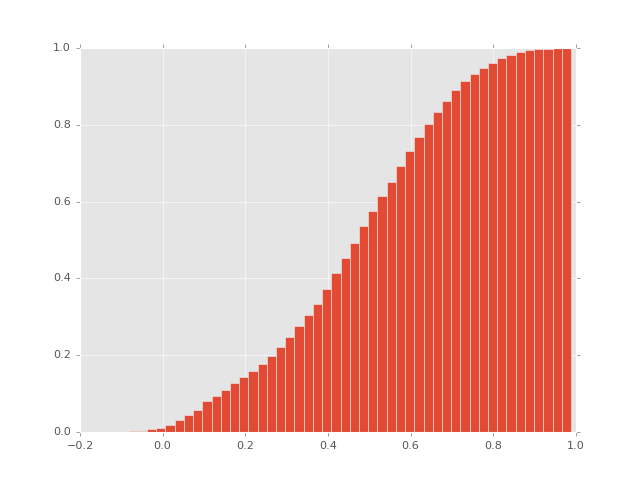

In [20]:
plt.figure()
df_topic_similars["jensen-shannon"]["we_sim"].hist(bins=50, cumulative=True, normed=True)

In [21]:
def join_to_get_word_prob(df_param):
    df_result = df_param.merge(df_topic_probs_full[["word", "word-prob"]],
                               left_on="similar_word", right_on="word",
                               suffixes=('', '_y'))
    del df_result["word_y"]
    return df_result

In [22]:
df_sim = join_to_get_word_prob(df_topic_similars["bhattacharyya"])
df_sim = df_sim[(df_sim["word-prob"] >= word_prob_lower_threshold) &
                (df_sim["word-prob"] <= word_prob_upper_threshold)]

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/tools/merge.py:714: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  rlab = rizer.factorize(rk)


### High TM similarity, low WE similarity

In [23]:
df_high_tm_low_we = df_sim[(df_sim["we_sim"] < 0.4)]
df_high_tm_low_we.iloc[np.random.permutation(len(df_high_tm_low_we))]

,word,similar_word,tm_sim,we_sim,word-prob
18573,monument,flagstones,0.772262,0.270321,2.351414e-07
23278,cards,djmax,0.836673,0.303376,2.618171e-07
14808,american,jay,0.664744,0.174906,4.067452e-05
9720,cuisine,momofuku,0.958693,0.263991,1.679581e-07
18129,delhi,lathi,0.964216,0.357408,1.956218e-07
17111,madrid,argentine,0.923548,0.341278,3.785183e-05
16802,law,attorneys,0.765067,0.386007,1.168495e-05
9771,greece,dhekelia,0.933184,0.306799,1.926578e-07
5799,city,neighboring,0.648637,0.248059,3.765621e-05
6674,album,pop-oriented,0.960294,0.397142,5.947693e-07


### High TM similarity, high WE similarity

In [24]:
df_high_tm_low_we = df_sim[(df_sim["we_sim"] > 0.8)]
df_high_tm_low_we.iloc[np.random.permutation(len(df_high_tm_low_we))]

,word,similar_word,tm_sim,we_sim,word-prob
10529,shah,akbar,0.933788,0.859334,6.987058e-06
9179,president,vice-president,0.842706,0.820344,2.448434e-05
24271,miss,pageant,0.854207,0.819474,2.145912e-05
18922,miller,dunn,0.855836,0.821616,1.231923e-05
12011,daughter,step-daughter,0.874835,0.822123,4.100154e-07
7112,cells,epithelial,0.890961,0.852985,3.481673e-06
24493,rifle,rifles,0.913138,0.826603,2.494870e-05
19569,label,labels,0.908865,0.805011,2.640400e-05
23810,helsinki,turku,0.975045,0.810423,3.786962e-06
15477,disease,sepsis,0.874862,0.806278,1.333785e-06


### Low TM similarity, high WE similarity

In [25]:
df_embedding_similars = pnd.read_csv("../models/word-embeddings/embedding.model.skip-gram.similars.with-tm",
                                 sep="\t", header=None)
df_embedding_similars.columns = ["word", "similar_word", "we_sim", "tm_sim"]
df_embedding_similars.head()

,word,similar_word,we_sim,tm_sim
0,announcer,sportscaster,0.741271,0.856420
1,announcer,announcers,0.739855,0.929492
2,announcer,play-by-play,0.721995,0.824415
3,shipbuilding,drydock,0.705620,0.756655
4,shipbuilding,shipyards,0.691392,0.853786


<IPython.core.display.Javascript object>


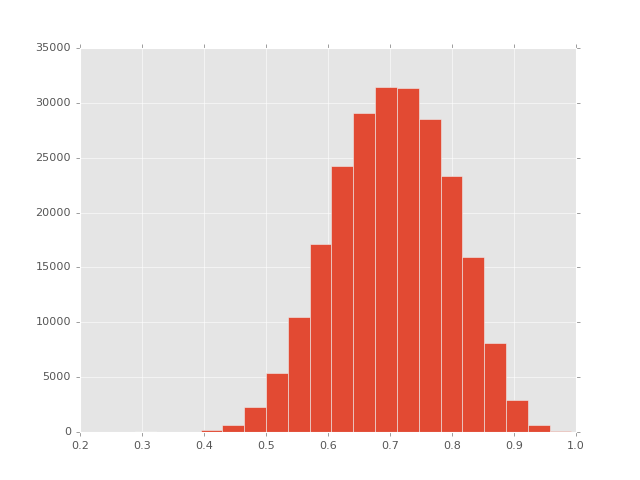

In [26]:
plt.figure()
df_embedding_similars["we_sim"].hist(bins=20)

<IPython.core.display.Javascript object>


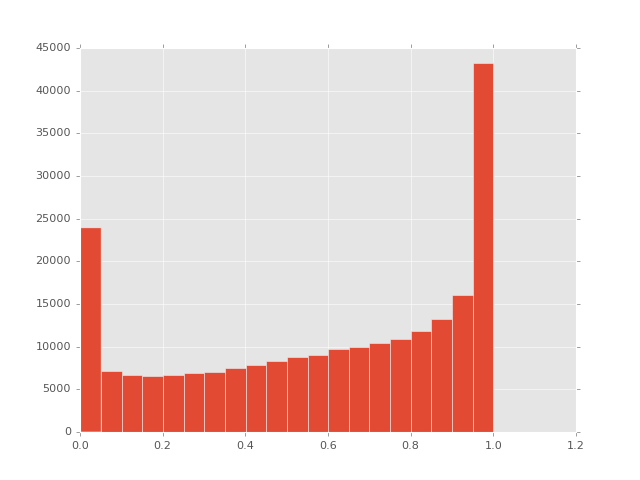

In [27]:
plt.figure()
df_embedding_similars["tm_sim"].hist(bins=20)

<IPython.core.display.Javascript object>


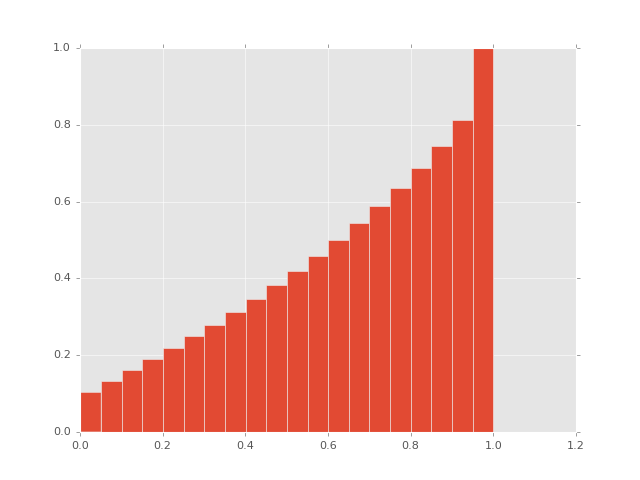

In [28]:
plt.figure()
df_embedding_similars["tm_sim"].hist(bins=20, cumulative=True, normed=True)

In [29]:
df_sim2 = join_to_get_word_prob(df_embedding_similars)
df_sim2 = df_sim2[(df_sim2["word-prob"] >= word_prob_lower_threshold) &
                 (df_sim2["word-prob"] <= word_prob_upper_threshold)]

In [30]:
df_embedding_similars[df_embedding_similars["word"] == "france-based"]

,word,similar_word,we_sim,tm_sim
99908,france-based,belgium-based,0.752608,0.245589
99909,france-based,switzerland-based,0.742562,0.343845
99910,france-based,netherlands-based,0.711484,0.297970


In [31]:
df_low_tm_high_we = df_sim2[(df_sim2["tm_sim"] > 0.0) &
                            (df_sim2["tm_sim"] < 0.4)]
df_low_tm_high_we

,word,similar_word,we_sim,tm_sim,word-prob
18,thrashers,braves,0.685548,0.175429,1.572187e-05
34,obscenity,sedition,0.715250,0.176227,2.615207e-06
40,downloads,subscribers,0.687755,0.375498,1.269961e-05
42,proposition,paragraph,0.528047,0.324924,6.761796e-06
43,xvi-c,paragraph,0.447301,0.048870,6.761796e-06
269,payne,bennett,0.822779,0.198622,2.891547e-05
270,reeves,bennett,0.749370,0.188538,2.891547e-05
271,goodwin,bennett,0.735547,0.126398,2.891547e-05
272,pollard,bennett,0.676034,0.201049,2.891547e-05
274,lockhart,bennett,0.713061,0.315204,2.891547e-05


# Findings

* syntatic variations play a bigger role in WE models, example:

  **(development, developed)**: TM-sim: 0.960519 WE-SIM: 0.360895
  
  **(composed, composers)** TM-SIM: 0.973376 WE-SIM: 0.329483
  
  **(works, working)** TM-SIM: 0.969470 WE-SIM: 0.274090
* topic models are better at capturing loose relationships, such as:

  **(war, commander)** TM-SIM: 0.922352 WE-SIM: 0.187498
  
  **(living, households)** TM-SIM: 0.983162 WE-SIM: 0.207906
  
  **(county, rural)** TM-SIM: 0.882099 WE-SIM: 0.257984
  

# Concept categorization in TM and WE

Roughly the same results after using the same algorithm for both systems

In [32]:
def get_embedding_from_word_embedding(word):
    try:
        return vectors[word]
    except:
        return vectors["this"]

columns = [str(i) for i in range(256)]
def get_embedding_from_topics(word):
    df_row = df_topic_probs_full[df_topic_probs_full["word"] == word]
    assert len(df_row) == 1, "not exactly one row found: " + word + " " + len(df_row)
    return df_row[columns].iloc[0,:].tolist()

def get_df_concept(embedding_function):
    df_concept = pnd.read_csv(
        "/home/knub/Repositories/master-thesis/data/concept-categorization/battig_concept-categorization.tsv",
        sep="\t",
        header=None)
    df_concept.columns = ["word", "concept"]
    df_concept["embeddings"] = df_concept["word"].apply(embedding_function)
    return df_concept

df_we_concept = get_df_concept(get_embedding_from_word_embedding)
df_tm_concept = get_df_concept(get_embedding_from_topics)
df_tm_concept.head(2)

,word,concept,embeddings
0,dog,land-mammals,"[0.00352872698013, 2.17180189723e-08, 9.670517..."
1,elephant,land-mammals,"[4.18416122346e-08, 7.66164594561e-08, 0.00046..."


In [33]:
len(df_tm_concept.ix[0,"embeddings"])

256

In [34]:
from sklearn import metrics

# http://stats.stackexchange.com/questions/95731/how-to-calculate-purity
def single_cluster_purity(df_param):
    return df_param["concept"].value_counts().max()

def calculate_purity(df_param):
    purity = float(sum([single_cluster_purity(df_cluster_group)
                        for _, df_cluster_group
                        in df_param.groupby("cluster_id")])) / len(df_param)
    return purity


def evaluate_clustering_algorithm(df_param, clustering):
    X = np.array(df_param["embeddings"].tolist())
    X_sim = metrics.pairwise.pairwise_distances(X, metric="cosine")
    # sim or not sim? PCA or not PCA?
    clusters = clustering.fit_predict(pca(X_sim, 20))
    df_param["cluster_id"] = clusters
    return calculate_purity(df_param)

In [41]:
for df_concept in [df_we_concept, df_tm_concept]:
    print "-" * 100
    for clustering in [KMeans(n_clusters=10, init="k-means++", n_jobs=1)]:
        print clustering.__class__.__name__
        print evaluate_clustering_algorithm(df_concept, clustering)

----------------------------------------------------------------------------------------------------
KMeans
0.780487804878
----------------------------------------------------------------------------------------------------
KMeans
0.792682926829


In [35]:
for df_concept in [df_we_concept, df_tm_concept]:
    print "-" * 100
    for clustering in [KMeans(n_clusters=10, init="k-means++", n_jobs=1),
                       AgglomerativeClustering(n_clusters=10, linkage="ward"),
                       AgglomerativeClustering(n_clusters=10, linkage="complete"),
                       AgglomerativeClustering(n_clusters=10, linkage="average"),
                       AffinityPropagation(damping=0.5),
                       AffinityPropagation(damping=0.6),
                       AffinityPropagation(damping=0.7),
                       AffinityPropagation(damping=0.8),
                       AffinityPropagation(damping=0.9),
                   SpectralClustering(n_clusters=3)]:
        print clustering.__class__.__name__
        print evaluate_clustering_algorithm(df_concept, clustering)

----------------------------------------------------------------------------------------------------
KMeans
0.780487804878
AgglomerativeClustering
0.756097560976
AgglomerativeClustering
0.719512195122
AgglomerativeClustering
0.719512195122
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
SpectralClustering
0.353658536585
----------------------------------------------------------------------------------------------------
KMeans
0.792682926829
AgglomerativeClustering
0.792682926829
AgglomerativeClustering
0.792682926829
AgglomerativeClustering
0.792682926829
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
AffinityPropagation
0.707317073171
SpectralClustering
0.365853658537


# Word Similarity

## Similarity

In [36]:
def word_similarity(f):
    try:        
        df_sim = pnd.read_csv(MODEL + f, sep="\t")
        df_sim["embedding-sim"] = df_sim[["word1", "word2"]].apply(
            lambda x: model.get_similarity(x["word1"], x["word2"], vectors), axis=1)
        topic_sim_column = df_sim.columns[3]
        
        topic_corr     = df_sim[["human-sim", topic_sim_column]].corr("spearman").ix[0,1]
        embedding_corr = df_sim[["human-sim", "embedding-sim"]].corr("spearman").ix[0, 1]
        
        return pnd.DataFrame([[topic_corr, embedding_corr]],
                             columns=["topic_corr", "embedding_corr"],
                             index=[f])
    except Exception as e:
        return None

df_tmp = pnd.concat([word_similarity(".wordsim353-all-bhattacharyya"),
            word_similarity(".wordsim353-all-hellinger"),
            word_similarity(".wordsim353-all-jensen-shannon"),
            word_similarity(".wordsim353-all-sum"),
            word_similarity(".wordsim353-rel-bhattacharyya"),
            word_similarity(".wordsim353-rel-hellinger"),
            word_similarity(".wordsim353-rel-jensen-shannon"),
            word_similarity(".wordsim353-rel-sum"),
            word_similarity(".wordsim353-sim-bhattacharyya"),
            word_similarity(".wordsim353-sim-hellinger"),
            word_similarity(".wordsim353-sim-jensen-shannon"),
            word_similarity(".wordsim353-sim-sum")])
df_tmp.sort_values(by="topic_corr", ascending=False)

,topic_corr,embedding_corr
.wordsim353-sim-bhattacharyya,0.629259,0.743211
.wordsim353-sim-hellinger,0.629104,0.743211
.wordsim353-sim-jensen-shannon,0.626463,0.743211
.wordsim353-sim-sum,0.613472,0.743211
.wordsim353-all-bhattacharyya,0.577273,0.656986
.wordsim353-all-hellinger,0.577256,0.656986
.wordsim353-all-jensen-shannon,0.571601,0.656986
.wordsim353-all-sum,0.554150,0.656986
.wordsim353-rel-hellinger,0.526983,0.572367
.wordsim353-rel-bhattacharyya,0.526891,0.572367


## Word Similarity performance with lower embedding dimensions

### Create word embeddings with different sizes

In [3]:
orig_vectors = load_skip_gram()

In [15]:
#orig_vectors.save_word2vec_format("/home/knub/Repositories/master-thesis/data/word-similarity/wordsim353_sim_rel/dim-200.embedding", binary=False)

In [11]:
with open("/home/knub/Repositories/master-thesis/data/word-similarity/wordsim353_sim_rel/dim-200.embedding", "r", encoding="utf-8") as f:
    lines = [line.rstrip() for line in f]
    count = int(lines[0].split(" ")[0])
    lines = lines[1:]
    words = []
    vectors = []
    for line in lines:
        split = line.split(" ")
        word = split[0]
        words.append(word)
        vector = [float(s) for s in split[1:]]
        vectors.append(vector)       
    del lines
X = np.array(vectors)
print "Read embeddings"

Read embeddings


In [13]:
print X.shape
print len(words)

(386046, 200)
386046


In [68]:
def project_down(n):
    with open("/home/knub/Repositories/master-thesis/data/word-similarity/wordsim353_sim_rel/dim-%d.embedding" % n, "w", encoding="utf-8") as f:
        f.write("%d %d\n" % (count, n))
        pca_X = pca(X, n)
        for i in range(count):
            vector = pca_X[i,:]
            output_vector = " ".join([str(v) for v in vector])
            f.write("%s %s\n" % (words[i], output_vector))

DIMENSIONS = [110, 120, 130, 140]
for n in [d for d in DIMENSIONS if d != 200]:
    print n
    project_down(n)
    gc.collect()
        
        



110


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


120


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


130


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


140


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


### Evaluate performance

In [69]:
df_wordsim353 = pnd.read_csv("/home/knub/Repositories/master-thesis/data/word-similarity/wordsim353_sim_rel/wordsim_all_goldstandard.txt",
                            sep="\t", header=None, names=["word1", "word2", "similarity"])

def get_similarity(word1, word2, v):
    # ugly but works for now
    if word1 not in v:
        if word1.lower() in v:
            word1 = word1.lower()
        if word1.upper() in v:
            word1 = word1.upper()
        if word1.title() in v:
            word1 = word1.title()
    if word2 not in v:
        if word2.lower() in v:
            word2 = word2.lower()
        if word2.upper() in v:
            word2 = word2.upper()
        if word2.title() in v:
            word2 = word2.title()
    try:
        return v.similarity(word1, word2)
    except KeyError:
        print word1, word2
        if word1 not in v:
            print word1
        if word2 not in v:
            print word2

def evaluate():
    for dim in DIMENSIONS:
        gc.collect()
        print dim
        vectors = gensim.models.word2vec.Word2Vec.load_word2vec_format(
            "/home/knub/Repositories/master-thesis/data/word-similarity/wordsim353_sim_rel/dim-%d.embedding" % dim,
            binary=False)
        df_wordsim353["dim-%d" % dim] = df_wordsim353[["word1", "word2"]].apply(
            lambda x: get_similarity(x["word1"], x["word2"], vectors), axis=1)

evaluate()
gc.collect()

110
120
130
140


14

In [70]:
for dim in DIMENSIONS:
    print dim
    print df_wordsim353["similarity"].corr(df_wordsim353["dim-%d" % dim])

110
0.616322039816
120
0.623648522916
130
0.620805117798
140
0.630749337877
